# Dat 402 Project 2
Christian Olivares-Rodriguez

### Libraries

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2

### Importing Data

In [61]:
df = pd.read_csv("/home/colivar8/bank-full.csv", delimiter = ';')
display(df.head(5))
print(df.shape)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


(45211, 17)


### Bank Marketing

The data is from the marketing campaigns of a Portuguese banking institution where the campaign was based on phone calls to clients. It often required more than one phone call to the same client to access if they would subscribe to a bank term deposit.

The dataset can be found in the UC Irvine Machine Learning Repository in the following link:
https://archive.ics.uci.edu/dataset/222/bank+marketing

My goal is to find the best Machine Learning model for predicting whether a client will subscribe to a term deposit. I will achive this by using categorical variables and numerical variables within the data. The reason why this is significant is because it enables the bank to focus their efforts on clients that would most likely subscribe, thus optimizing their resource allocation.

<p>The dataset contains 16 features:</p>   
<li>age</li>
<li>job</li>	
<li>marital</li>
<li>education</li>
<li>default</li>
<li>balance</li>
<li>housing</li>
<li>loan</li>
<li>contact</li>
<li>month</li>
<li>duration</li>
<li>campaign</li>
<li>pdays</li>
<li>previous: </li>
<li>poutcome</li>
<li>y</li>

### Data Frame Copy
Starting off first with creating a copy of the dataframe and seeing some unique variables within the data.

In [62]:
df_copy = df.copy()

columns = ['education', 'job', 'marital', 'contact', 'poutcome']

for column in columns:
    unique_categories = df_copy[column].unique()
    print(f"{column}: {unique_categories}")

education: ['tertiary' 'secondary' 'unknown' 'primary']
job: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital: ['married' 'single' 'divorced']
contact: ['unknown' 'cellular' 'telephone']
poutcome: ['unknown' 'failure' 'other' 'success']


By printing out some unique variables I noticed that some of the data contained 'unknown' or 'other' which aren't helpful with determining the outcome.

So, I filtered the data by replacing them with NAs and then removing the rows with NAs.
Along with checking if the data was filtered correctly.

In [63]:
df_copy.replace(['unknown', 'other'], pd.NA, inplace = True)

df_copy = df_copy.dropna()
display(df_copy.head(5))
print(df_copy.shape)

na_columns = df_copy.isna().any()
print(na_columns)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
24060,33,admin.,married,tertiary,no,882,no,no,telephone,21,oct,39,1,151,3,failure,no
24064,33,services,married,secondary,no,3444,yes,no,telephone,21,oct,144,1,91,4,failure,yes
24077,36,management,married,tertiary,no,0,yes,no,telephone,23,oct,140,1,143,3,failure,yes
24127,51,admin.,single,secondary,no,3132,no,no,telephone,5,nov,449,1,176,1,failure,no
24151,33,unemployed,divorced,secondary,no,1005,yes,no,telephone,10,nov,175,1,174,2,failure,no


(6092, 17)
age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool


- After the filtering there was a substantial reduction in rows from 45,211 before filtering to 6,092 after the filter was applied.

### Visualizing data
Next up some visualizations to get more fimiliar with the data by creating some plots.
So, I checked on the amount of clients that said yes and no for each month.

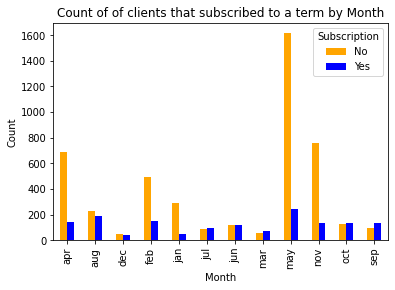

In [64]:
counts = df_copy.groupby(['month', 'y']).size().unstack(fill_value = 0)

counts.plot(kind = 'bar', stacked = False, color = {"no": "orange", "yes": "blue"})
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Count of of clients that subscribed to a term by Month')
plt.legend(title = 'Subscription',
           labels = ['No', 'Yes'])
plt.show()

- It turns out that May is the month with the highest number of both sign-ups and non-sign-ups. 

Then I checked on the relationship between a client's age and the likeliness that they will subscribe to a term deposit.

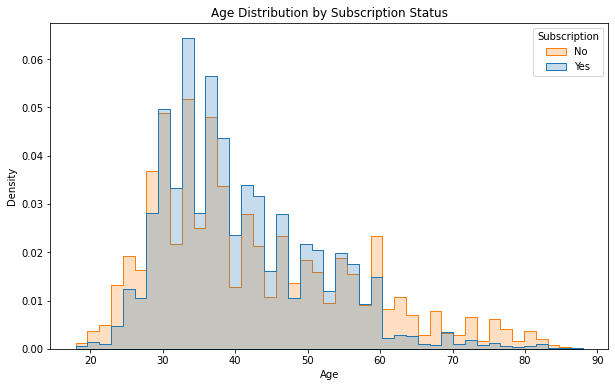

In [65]:
plt.figure(figsize = (10, 6))
sns.histplot(data = df_copy,
             x = 'age',
             hue = 'y',
             element = 'step',
             stat ='density',
             common_norm = False)
plt.title('Age Distribution by Subscription Status')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend(title = 'Subscription',
           labels = ['No', 'Yes'])
plt.show()

- It appears that subscriptions peak when a client's age is 30 and drop off heavily by age 60.
- Alongside that, the age distribution of clients who do not subscribe is more even than that of those who do.

Next up, a plot to see the different job types and their likeliness to subscribe or not.

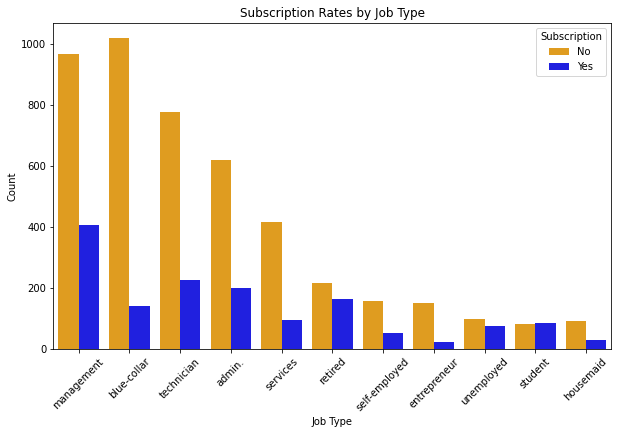

In [66]:
plt.figure(figsize = (10, 6))
sns.countplot(data = df_copy,
              x = 'job',
              hue = 'y',
              order = df_copy['job'].value_counts().index,
              palette = {"no": "orange", "yes": "blue"})
plt.title('Subscription Rates by Job Type')
plt.xlabel('Job Type')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.legend(title = 'Subscription',
           labels = ['No', 'Yes'])
plt.show()

- Management has the most amount of people subscribing and Blue-collar has the most amount of people deciding to not subscribe to a term deposit.



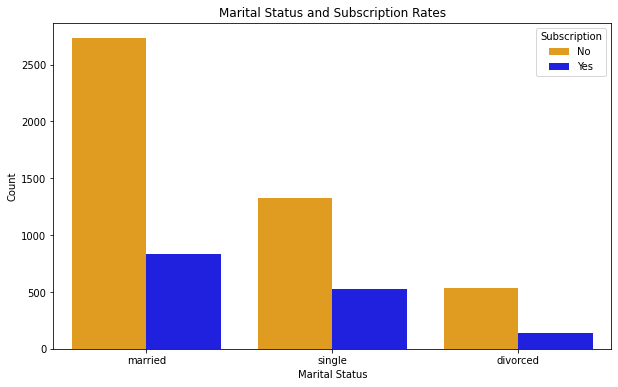

In [67]:
plt.figure(figsize = (10, 6))
sns.countplot(data = df_copy,
              x = 'marital',
              hue = 'y',
             palette = {"no": "orange", "yes": "blue"})
plt.title('Marital Status and Subscription Rates')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.legend(title = 'Subscription', labels = ['No', 'Yes'])
plt.show()

- There are more people that are married in the data set than single and divored.

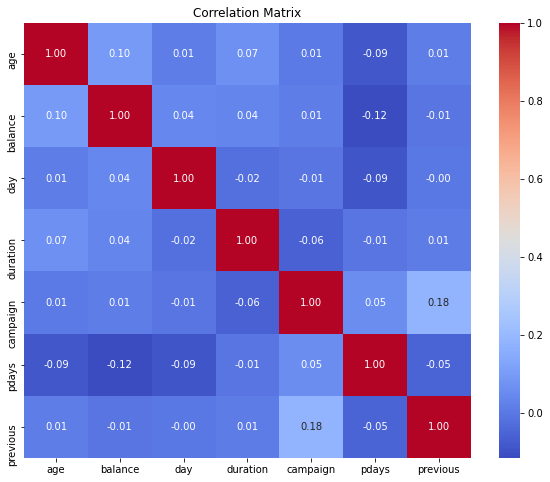

In [68]:
plt.figure(figsize = (10, 8))
sns.heatmap(df_copy.corr(),
            annot = True,
            fmt = ".2f", cmap = 'coolwarm')
plt.title('Correlation Matrix')
plt.show()

- The highest correlation was between campaign and previous

### K-means

First I identified which columns are categorical and numerical. Then I setup a transformer that scales numerical variable and converts categorical varaibles.

In [69]:
categorical_cols = df_copy.select_dtypes(include = ['object', 'bool']).columns
numerical_cols = df_copy.select_dtypes(include = ['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers = [('num', StandardScaler(), numerical_cols),('cat', OneHotEncoder(), categorical_cols)])

The preprocessor is applied, Kmeans algorithm is applied creating it's own column within the data frame. PCA was applied in order to visualize the data in two dimensions and then plotted.

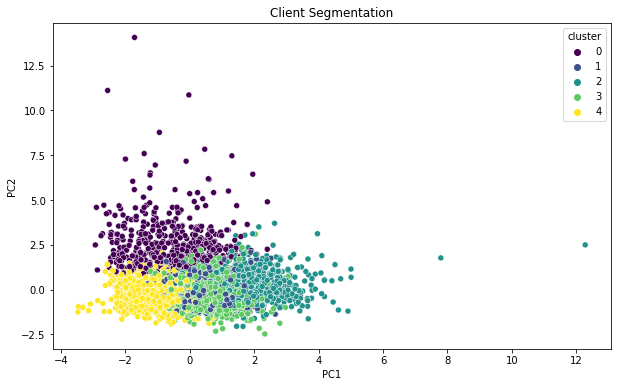

In [70]:
processed_data = preprocessor.fit_transform(df_copy)

kmeans = KMeans(n_clusters = 5, n_init = 10, random_state = 0)
clusters = kmeans.fit_predict(processed_data)
df_copy['cluster'] = clusters

pca = PCA(n_components = 2)
reduced_data = pca.fit_transform(processed_data)

plot_df = pd.DataFrame(reduced_data, columns = ['PC1', 'PC2'])
plot_df['cluster'] = clusters

plt.figure(figsize = (10, 6))
sns.scatterplot(data = plot_df, x = 'PC1', y = 'PC2', hue = 'cluster', palette = 'viridis')
plt.title('Client Segmentation')
plt.show()

- Cluster 0 has the biggest out liars

In [71]:
print(df_copy.shape)

(6092, 18)


### Reseting Copy of the data frame

In [72]:
df_copy = df.copy()
df_copy.replace(['unknown', 'other'], pd.NA, inplace = True)

df_copy = df_copy.dropna()
print(df_copy.shape)

(6092, 17)


### New Pipeline

I created a pipeline by droping the target variable, then converting it to binary, split the data to 20 percent for testing and 80 percent for training, identified the feature types, created a transformer, and then put the processed data in X_train_processed and X_test_processed.

In [73]:
X = df_copy.drop('y', axis = 1)
y = df_copy['y'].apply(lambda x: 1 if x == 'yes' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
#This code was assisted by ChatGPT
categorical_features = [col for col in X.columns if X[col].dtype == 'object']
numerical_features = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
#End
preprocessor = ColumnTransformer(
    transformers = [('num', StandardScaler(), numerical_features),
                    ('cat', OneHotEncoder(), categorical_features)])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

- Now that my pipeline is all set I created some models to see which one would be best to predict if the client will subscribe to a term deposit.

### Logistic Regression

In [74]:
logistic_model = LogisticRegression(max_iter = 1000)

logistic_model.fit(X_train_processed, y_train)

y_pred = logistic_model.predict(X_test_processed)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(f"Logistic Regression Precision: {precision:.4f}")
print(f"Logistic Regression Recall: {recall:.4f}")
print(f"Logistic Regression F1 Score: {f1:.4f}")

Logistic Regression Accuracy: 0.8335
Logistic Regression Precision: 0.6652
Logistic Regression Recall: 0.5484
Logistic Regression F1 Score: 0.6012


### Random Forest classifier

In [75]:
random_forest_model = RandomForestClassifier(n_estimators = 100, random_state = 123)

random_forest_model.fit(X_train_processed, y_train)

y_pred_rf = random_forest_model.predict(X_test_processed)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"Random Forest Model Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest Model Precision: {precision_rf:.4f}")
print(f"Random Forest Model Recall: {recall_rf:.4f}")
print(f"Random Forest Model F1 Score: {f1_rf:.4f}")

Random Forest Model Accuracy: 0.8556
Random Forest Model Precision: 0.7210
Random Forest Model Recall: 0.6022
Random Forest Model F1 Score: 0.6562


### k-NN Neighbors

In [76]:
knn_model = KNeighborsClassifier(n_neighbors = 11)

knn_model.fit(X_train_processed, y_train)

y_pred_knn = knn_model.predict(X_test_processed)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

print(f"k-NN Model Accuracy: {accuracy_knn:.4f}")
print(f"k-NN Model Precision: {precision_knn:.4f}")
print(f"k-NN Model Recall: {recall_knn:.4f}")
print(f"k-NN Model F1 Score: {f1_knn:.4f}")


k-NN Model Accuracy: 0.8326
k-NN Model Precision: 0.6829
k-NN Model Recall: 0.5018
k-NN Model F1 Score: 0.5785


### Artifical Neural Network

For the ANN, I created a three-layer model where the first layer has 128 neurons, second has 64 neurons, and the third has 1. Which is then compiled with the Adam optimizer and metrics that are processed during training by model.fit and then evaluated on the test data set.

In [77]:
# This code was assisted by ChatGPT
model = Sequential([
    Dense(128,
          activation = 'relu',
          input_shape = (X_train_processed.shape[1],),
          kernel_regularizer = l2(0.01)),
    Dense(64,
          activation = 'relu',
          kernel_regularizer = l2(0.01)),
    Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = Adam(),
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])

history = model.fit(X_train_processed,
                    y_train,
                    epochs = 40,
                    batch_size = 64,
                    validation_split = 0.25)

test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test_processed, y_test)
test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
#End

Epoch 1/40
58/58 [==============================] - 4s 32ms/step - loss: 1.5890 - accuracy: 0.7682 - precision: 0.6465 - recall: 0.2162 - val_loss: 1.1072 - val_accuracy: 0.8417 - val_precision: 0.7023 - val_recall: 0.5393
Epoch 2/40
58/58 [==============================] - 0s 5ms/step - loss: 0.8924 - accuracy: 0.8363 - precision: 0.7189 - recall: 0.5964 - val_loss: 0.7085 - val_accuracy: 0.8515 - val_precision: 0.6762 - val_recall: 0.6786
Epoch 3/40
58/58 [==============================] - 0s 6ms/step - loss: 0.6174 - accuracy: 0.8391 - precision: 0.7034 - recall: 0.6464 - val_loss: 0.5324 - val_accuracy: 0.8515 - val_precision: 0.6840 - val_recall: 0.6571
Epoch 4/40
58/58 [==============================] - 0s 4ms/step - loss: 0.4973 - accuracy: 0.8437 - precision: 0.7190 - recall: 0.6432 - val_loss: 0.4609 - val_accuracy: 0.8507 - val_precision: 0.6701 - val_recall: 0.6893
Epoch 5/40
58/58 [==============================] - 0s 6ms/step - loss: 0.4435 - accuracy: 0.8451 - precision: 

In [78]:
print(f"ANN Model Accuracy: {test_acc:.4f}")
print(f"ANN Model Precision: {test_precision:.4f}")
print(f"ANN Model Recall: {test_recall:.4f}")
print(f"ANN Model F1 Score: {test_f1_score:.4f}")

ANN Model Accuracy: 0.8400
ANN Model Precision: 0.6810
ANN Model Recall: 0.5663
ANN Model F1 Score: 0.6184


### History plot

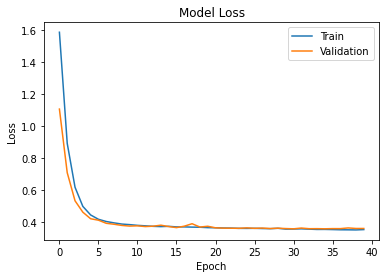

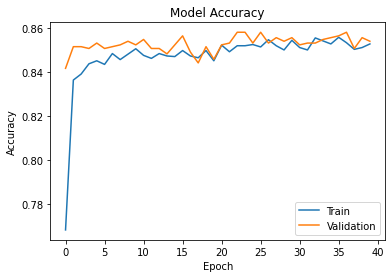

In [79]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

### Compare Results

Now that I have all the models ready I put them into a data frame.

In [80]:
data = {'Model': ['Logistic Regression','Random Forest','k-NN','ANN'],
        'Accuracy': [accuracy, accuracy_rf, accuracy_knn, test_acc],
        'Precision': [precision,precision_rf,precision_knn, test_precision],
        'Recall': [recall,recall_rf,recall_knn, test_recall],
        'F1 Score': [f1, f1_rf, f1_knn, test_f1_score]}

results_df = pd.DataFrame(data)

print(results_df)

                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.833470   0.665217  0.548387  0.601179
1        Random Forest  0.855619   0.721030  0.602151  0.656250
2                 k-NN  0.832650   0.682927  0.501792  0.578512
3                  ANN  0.840033   0.681035  0.566308  0.618395


Then I plotted the results in a bar chart and found which Machine Learning Model was best in each category.

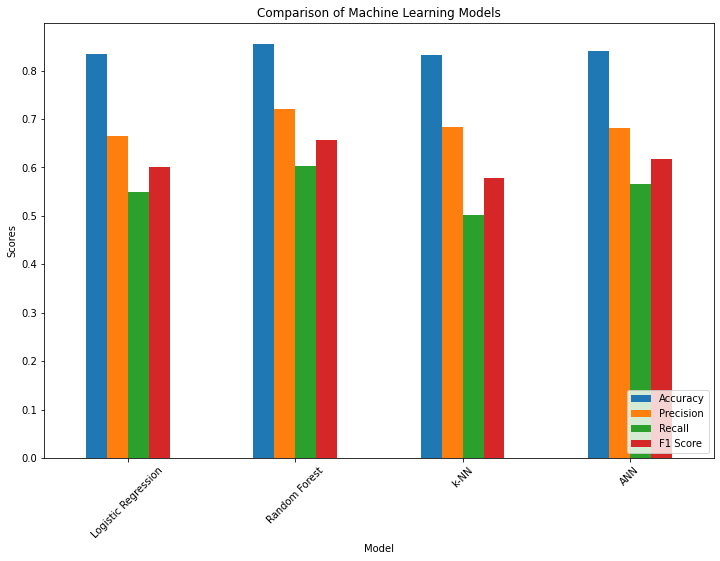

Best Accuracy: Random Forest with a score of 0.8556
Best Precision: Random Forest with a score of 0.7210
Best Recall: Random Forest with a score of 0.6022
Best F1 Score: Random Forest with a score of 0.6562


In [82]:
results_df.set_index('Model').plot(kind = 'bar', figsize = (12, 8))
plt.title('Comparison of Machine Learning Models')
plt.ylabel('Scores')
plt.xticks(rotation = 45)
plt.legend(loc = 'lower right')
plt.show()

#This code was assisted by ChatGPT
best_models = results_df.set_index('Model').idxmax()
for metric, model in best_models.iteritems():
    print(f"Best {metric}: {model} with a score of {results_df.set_index('Model').loc[model, metric]:.4f}")
#End

- With other times that I tested the ANN that I created, it would sometimes have the highest scores for Recall and F1 Scores

### Conclusion

Although the Artificial Neural Network that I created can occasionally have the highest Recall and F1 Scores, the results it achieves are not consistent if done multiple times. In comparison, Random Forest model is consistently having the highest scores of all four Machine learning models in Accuracy, Precision, Recall, and F1 Score. And it will provide the best prediction in comparison to the other machine learning models. This will enable the bank to have a Machine Learning Model that will help optimize their resource allocation.